In [90]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

import pca_dax.data_handler as dh

# Data Gathering and Preprocessing

In [61]:
# Initialise a data handler class instance
# It checks for DAX constituents in database or on web if none are found
# Then fetches the data (either from DB or Yahoo! Finance API)
# For constituents for the specified time period
data_instance = dh.DataHandler(
    index='DAX'
    , start_date='2010-01-01'
    , end_date='2023-08-01'
)

# Fetches raw data from the database in wide format, i.e. stocks as columns 
dax_data = data_instance.fetch_stocks_from_db(
    price_type='adj_close'
    , wide_format=True
)

dax_data.head()

,1COV.DE,1U1.DE,8TRA.DE,AAD.DE,ADJ.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,...,VNA.DE,VOS.DE,VOW3.DE,WAC.DE,WAF.DE,WCH.DE,WSU.DE,WUW.DE,ZAL.DE,ZO1.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,2.997455,NaN,9.118773,NaN,31.464582,2.525,10.414361,11.362466,21.803215,...,NaN,51.389050,37.498192,5.975751,NaN,81.023949,4.757605,9.949111,NaN,15.952764
2010-01-05,NaN,2.973282,NaN,9.430388,NaN,32.457432,2.670,10.680754,11.281304,21.880951,...,NaN,51.733070,36.771477,5.984904,NaN,81.624619,4.684784,9.973813,NaN,15.670896
2010-01-06,NaN,2.888676,NaN,9.408520,NaN,32.195934,2.810,10.722379,11.358408,22.772655,...,NaN,51.776981,37.788872,6.083480,NaN,83.026184,4.684784,10.128205,NaN,15.960182
2010-01-07,NaN,2.804071,NaN,9.430388,NaN,32.477859,2.650,10.722379,11.455798,22.946423,...,NaN,51.652546,38.224899,6.139808,NaN,81.090683,4.854699,10.066450,NaN,15.824193
2010-01-08,NaN,2.761768,NaN,9.567060,NaN,32.359364,2.720,10.722379,11.642469,22.786373,...,NaN,53.299393,38.637672,6.090520,NaN,80.323158,4.794016,10.189963,NaN,15.576940


In [55]:
print(len(dax_data))

3451


In [62]:
dax_data_clean = dax_data.dropna(
    axis=1
    , thresh=int(0.99*len(dax_data))
)

dax_data_clean.isna().sum()

1U1.DE     4
AAD.DE     4
ADS.DE     4
ADV.DE     4
AFX.DE     4
          ..
VOW3.DE    4
WAC.DE     4
WCH.DE     4
WSU.DE     4
WUW.DE     4
Length: 108, dtype: int64

In [66]:
dax_data_clean[dax_data_clean.isnull().any(axis=1)]

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,2.888676,9.408520,32.195934,2.810,10.722379,11.358408,22.772655,46.012665,4.270158,22.198751,...,24.209881,4.617673,7.893831,3.094023,51.776981,37.788872,6.083480,83.026184,4.684784,10.128205
2010-01-12,2.662659,9.345651,31.538137,2.720,10.755676,11.443623,20.938955,44.537174,4.195717,20.965212,...,23.430048,4.509686,7.865938,3.411359,52.699215,37.905148,6.091929,78.020592,4.684784,10.375237
2010-01-13,2.761768,9.293715,31.137726,2.690,10.788978,11.431449,20.760612,44.614292,4.212636,21.162476,...,23.771774,4.669212,7.938459,3.287951,52.640663,36.916821,6.266547,78.053963,4.581622,10.436991
2010-01-25,2.820388,9.080507,30.320564,2.460,10.073042,11.334061,20.362772,41.622181,4.229554,19.986368,...,21.366974,5.301182,8.216597,2.820762,52.230774,33.225143,6.147553,70.845901,4.702990,10.739603
2010-01-26,2.846374,9.370252,30.316484,2.538,9.981469,11.394929,20.161575,41.750706,4.060372,19.933928,...,21.149715,5.497522,8.268399,2.812828,51.791615,33.603027,6.334846,72.247459,4.684784,10.653145
2010-01-27,2.810115,9.266381,30.165306,2.446,9.848272,11.171741,20.010668,41.642742,4.009617,20.148674,...,20.732927,5.442302,8.407867,2.886873,53.833714,32.667027,6.355969,68.576698,4.702990,11.054565
2010-03-19,3.221660,9.993477,31.950788,3.489,10.133857,11.983342,22.955568,45.719612,5.126219,22.123838,...,22.253757,5.303636,9.021520,3.478352,54.514408,41.951458,6.019405,66.334183,5.552562,12.592326
2010-05-24,3.213804,10.747910,32.869251,3.981,9.326024,12.754368,20.755484,43.382271,4.778433,21.716654,...,18.857386,4.786250,7.932882,2.507834,53.044193,40.752365,6.700981,67.001923,5.107461,12.691136
2010-06-08,3.122654,11.333286,34.364807,4.010,9.474057,13.143937,17.590643,42.517651,4.795937,22.351948,...,18.147964,5.015991,7.658405,2.556316,52.683102,41.362213,7.220611,69.778191,4.863047,12.845529


In [58]:
# Preprocess the data: drop the stocks that have more than 1% of missing data
# Forward fill the rest 
dax_data = data_instance.preprocess()

# The number of stocks shrinks to 108 from 146
dax_data.head()

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2.997455,9.118773,31.464582,2.525,10.414361,11.362466,21.803215,45.519119,4.128044,22.398512,...,24.003975,4.423787,7.499338,2.908911,51.389050,37.498192,5.975751,81.023949,4.757605,9.949111
2010-01-05,2.973282,9.430388,32.457432,2.670,10.680754,11.281304,21.880951,45.657925,4.204177,22.058916,...,24.328173,4.479009,7.859563,3.067579,51.733070,36.771477,5.984904,81.624619,4.684784,9.973813
2010-01-06,2.888676,9.408520,32.195934,2.810,10.722379,11.358408,22.772655,46.012665,4.270158,22.198751,...,24.209881,4.617673,7.893831,3.094023,51.776981,37.788872,6.083480,83.026184,4.684784,10.128205
2010-01-07,2.804071,9.430388,32.477859,2.650,10.722379,11.455798,22.946423,45.483139,4.207561,22.051426,...,24.139786,4.509686,7.691406,3.094905,51.652546,38.224899,6.139808,81.090683,4.854699,10.066450
2010-01-08,2.761768,9.567060,32.359364,2.720,10.722379,11.642469,22.786373,45.236362,4.161881,21.984007,...,24.595419,4.479009,7.834059,3.243876,53.299393,38.637672,6.090520,80.323158,4.794016,10.189963


In [59]:
dax_data.isna().sum()

1U1.DE     0
AAD.DE     0
ADS.DE     0
ADV.DE     0
AFX.DE     0
          ..
VOW3.DE    0
WAC.DE     0
WCH.DE     0
WSU.DE     0
WUW.DE     0
Length: 108, dtype: int64

In [19]:
# Create daily price changes from the preprocessed data
rts = data_instance.create_daily_change()

rts.head()

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.008065,0.034173,0.031555,0.057426,0.025579,-0.007143,0.003565,0.003049,0.018443,-0.015162,...,0.013506,0.012483,0.048034,0.054546,0.006694,-0.019380,0.001532,0.007413,-0.015306,0.002483
2010-01-06,-0.028455,-0.002319,-0.008057,0.052434,0.003897,0.006835,0.040753,0.007770,0.015694,0.006339,...,-0.004862,0.030959,0.004360,0.008621,0.000849,0.027668,0.016471,0.017171,0.000000,0.015480
2010-01-07,-0.029289,0.002324,0.008757,-0.056939,0.000000,0.008574,0.007631,-0.011508,-0.014659,-0.006637,...,-0.002895,-0.023386,-0.025644,0.000285,-0.002403,0.011539,0.009259,-0.023312,0.036269,-0.006097
2010-01-08,-0.015086,0.014493,-0.003649,0.026415,0.000000,0.016295,-0.006975,-0.005426,-0.010857,-0.003057,...,0.018875,-0.006803,0.018547,0.048134,0.031883,0.010799,-0.008028,-0.009465,-0.012500,0.012270
2010-01-11,0.019694,-0.014286,0.006313,0.018015,0.007764,0.008017,-0.042545,-0.011251,0.006098,-0.011131,...,-0.023869,0.004110,0.007630,0.073370,0.005081,0.007373,0.017341,-0.002493,0.018987,0.017576


In [132]:
# Fetch the data about the companies from DB, retain only sectors
sectors_df = data_instance.fetch_info_from_db()[['symbol', 'industry', 'sector']]

sectors_df.head()

,symbol,industry,sector
0,1COV.DE,Specialty Chemicals,Basic Materials
1,1U1.DE,Telecom Services,Communication Services
2,8TRA.DE,Farm & Heavy Construction Machinery,Industrials
3,AAD.DE,Staffing & Employment Services,Industrials
4,ADJ.DE,Real Estate Services,Real Estate


In [22]:
sectors_df.sector.unique().tolist()

['Basic Materials',
 'Communication Services',
 'Industrials',
 'Real Estate',
 'Consumer Cyclical',
 'Technology',
 'Healthcare',
 'Financial Services',
 'Consumer Defensive',
 '',
 'Utilities']

In [134]:
sectors_df.industry.unique().tolist()

['Specialty Chemicals',
 'Telecom Services',
 'Farm & Heavy Construction Machinery',
 'Staffing & Employment Services',
 'Real Estate Services',
 'Footwear & Accessories',
 'Communication Equipment',
 'Medical Instruments & Supplies',
 'Aerospace & Defense',
 'Semiconductor Equipment & Materials',
 'Insurance - Diversified',
 'Software - Application',
 'Chemicals',
 'Drug Manufacturers - General',
 'Information Technology Services',
 'Auto Parts',
 'Household & Personal Products',
 'Waste Management',
 'Auto Manufacturers',
 'Apparel Manufacturing',
 'Entertainment',
 'Conglomerates',
 'Banks - Regional',
 'Specialty Retail',
 'Personal Services',
 'Financial Data & Stock Exchanges',
 'Asset Management',
 'Specialty Industrial Machinery',
 'Internet Retail',
 'Integrated Freight & Logistics',
 '',
 'Drug Manufacturers - Specialty & Generic',
 'Medical Devices',
 'Utilities - Renewable',
 'Utilities - Diversified',
 'Airports & Air Services',
 'Medical Care Facilities',
 'Engineering & 

# Modelling and EDA

## Central moments examination

In [88]:
# Vector of means of each of R_t
rts.mean()

1U1.DE     0.000620
AAD.DE     0.000911
ADS.DE     0.000688
ADV.DE     0.000976
AFX.DE     0.000830
             ...   
VOW3.DE    0.000577
WAC.DE     0.000670
WCH.DE     0.000452
WSU.DE     0.000782
WUW.DE     0.000242
Length: 108, dtype: float64

In [89]:
# Standard deviations of R_t
rts.std()

1U1.DE     0.022354
AAD.DE     0.020140
ADS.DE     0.018913
ADV.DE     0.027367
AFX.DE     0.018151
             ...   
VOW3.DE    0.021856
WAC.DE     0.023357
WCH.DE     0.024235
WSU.DE     0.020433
WUW.DE     0.014789
Length: 108, dtype: float64

Mean-Volatility Plot to see how the equities are placed against each other

In [115]:
# Calculates mean and standard deviations of return series and combines them in one table (with sectors)
mean_var_df = data_instance.create_mean_var_df()

mean_var_df.head()

,symbol,mean,vol,sector
0,1U1.DE,0.000620,0.022354,Communication Services
1,AAD.DE,0.000911,0.020140,Industrials
2,ADS.DE,0.000688,0.018913,Consumer Cyclical
3,ADV.DE,0.000976,0.027367,Technology
4,AFX.DE,0.000830,0.018151,Healthcare


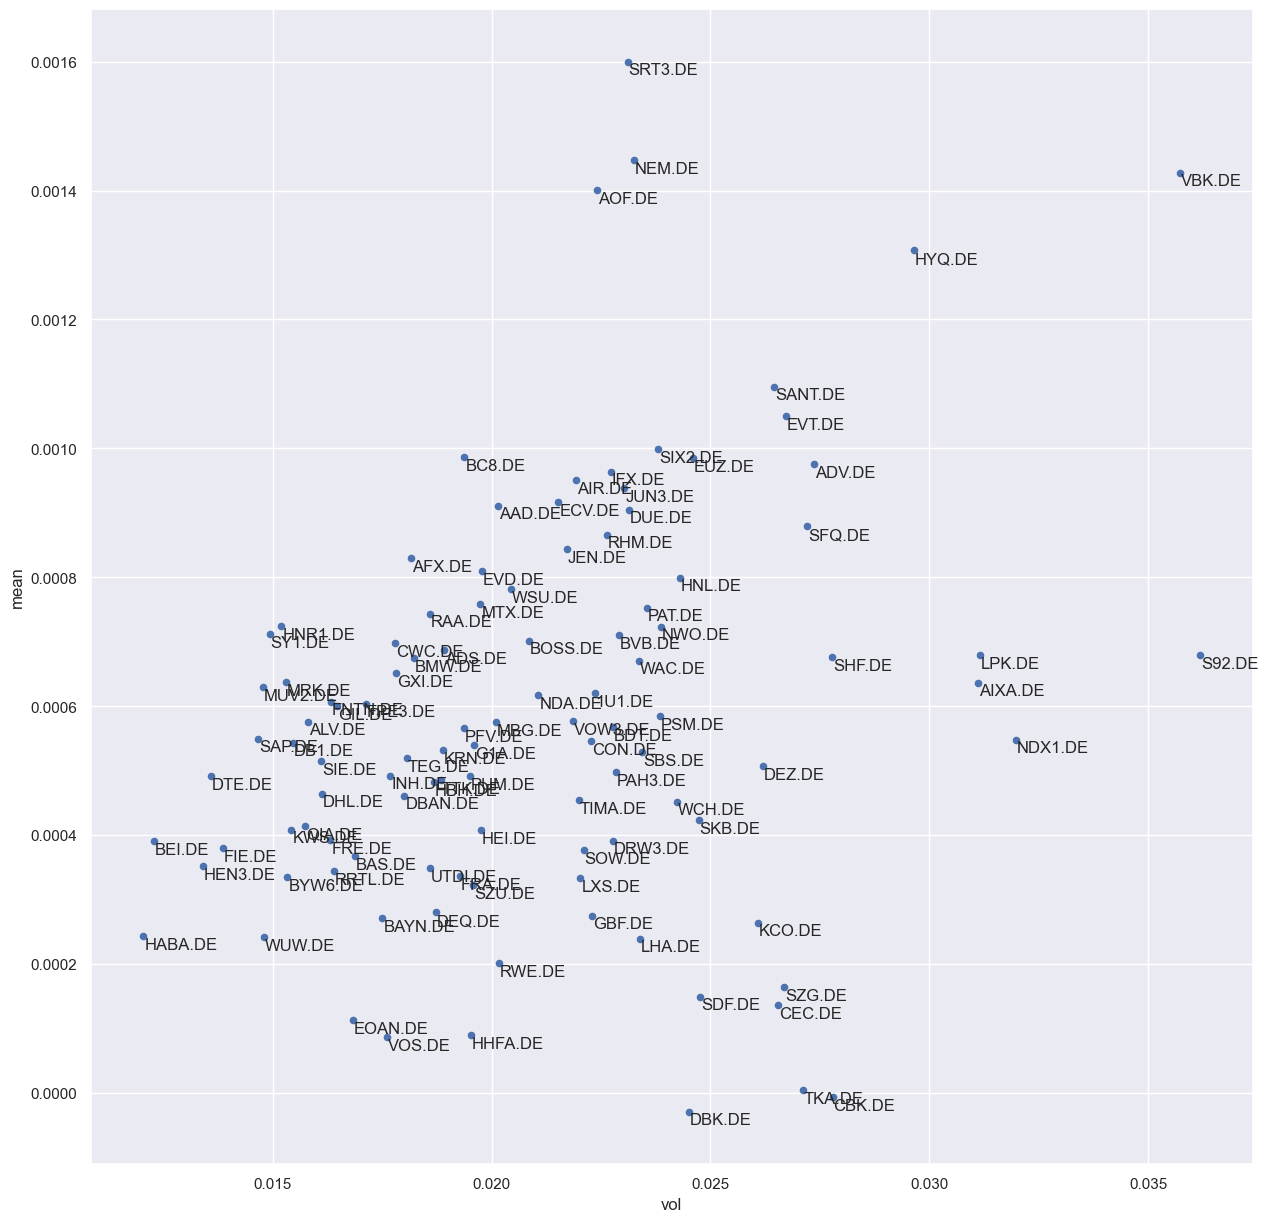

In [116]:
mean_var_df.plot(
    kind='scatter'
    , x='vol'
    , y='mean'
    , figsize=(15, 15)
)

for ticker in mean_var_df.symbol:
    plt.annotate(
        ticker
        , xy=(
            mean_var_df[mean_var_df.symbol == ticker]['vol'] + 0.00002
            , mean_var_df[mean_var_df.symbol == ticker]['mean'] - 0.00002
        )
    )

plt.show();

In [95]:
# Skewness
rts.skew()

1U1.DE    -2.729354
AAD.DE     0.082338
ADS.DE     0.486091
ADV.DE    -0.067668
AFX.DE     0.026872
             ...   
VOW3.DE   -0.178929
WAC.DE     0.013010
WCH.DE     0.038899
WSU.DE     0.222104
WUW.DE    -0.012608
Length: 108, dtype: float64

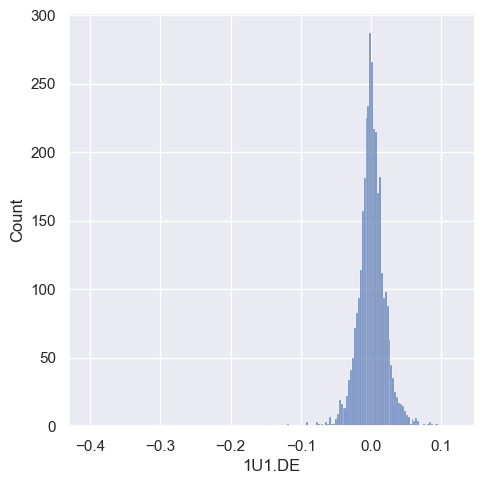

In [107]:
sns.displot(
    rts
    , x='1U1.DE'
    # , kind='kde'
);

In [114]:
rts[rts['1U1.DE'] == rts['1U1.DE'].min()]['1U1.DE']

date
2011-11-07   -0.403341
Name: 1U1.DE, dtype: float64

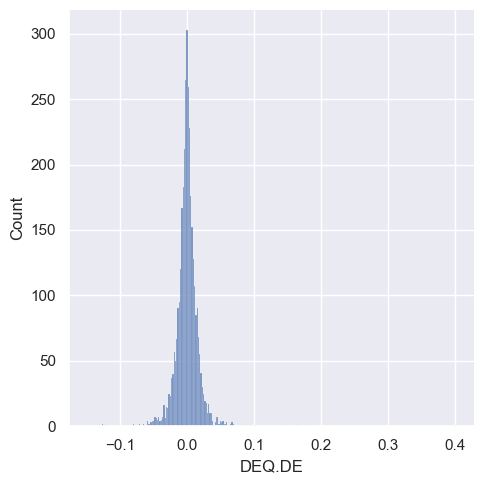

In [110]:
# High skewness example
sns.displot(
    rts
    , x='DEQ.DE'
    # , kind='kde'
);

In [112]:
rts[rts['DEQ.DE'] == rts['DEQ.DE'].max()]['DEQ.DE']

date
2022-05-23    0.401152
Name: DEQ.DE, dtype: float64

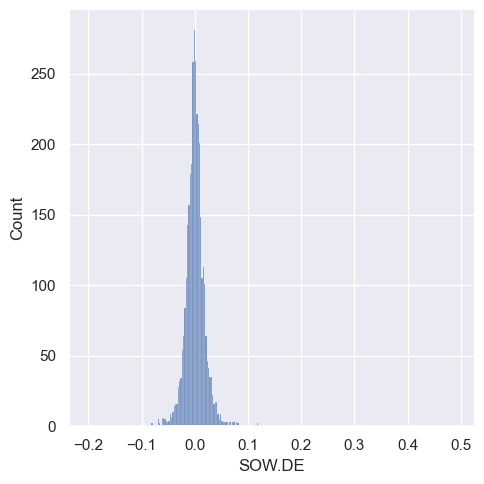

In [109]:
sns.displot(
    rts
    , x='SOW.DE'
    # , kind='kde'
);

In [96]:
# Unbiased kurtosis
rts.kurt() 

1U1.DE     44.689665
AAD.DE      4.258998
ADS.DE     10.261359
ADV.DE      6.993297
AFX.DE      3.727355
             ...    
VOW3.DE     8.339310
WAC.DE      3.347524
WCH.DE      2.794211
WSU.DE      5.212788
WUW.DE      9.460308
Length: 108, dtype: float64

### Jarque-Bera test

In [102]:
rts.apply(lambda t: stats.jarque_bera(t), axis=0)

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
0,290518.784174,2601.710241,15223.026718,7009.051752,1989.916762,20090.742693,19132.779633,17054.771259,2486.760097,2148.217308,...,14236.364897,4097.719108,35169.235919,6079.099747,6334.969495,9982.249946,1604.613574,1.118570e+03,3920.57123,12823.37706
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.275112e-243,0.00000,0.00000


## Durbin-Watson test for autocorrelation

In [86]:
from statsmodels.stats.stattools import durbin_watson

def dw_test(ts: pd.DataFrame) -> pd.DataFrame:
    dw_output = pd.DataFrame(index=ts.columns.to_list())
    
    for ticker in ts.columns:
        dw_output.loc[ticker, 'Durbin-Watson Statistic'] = durbin_watson(ts[ticker])
    
    return dw_output

In [87]:
dw_test(rts)

,Durbin-Watson Statistic
1U1.DE,2.024550
AAD.DE,1.997700
ADS.DE,1.951025
ADV.DE,2.085690
AFX.DE,2.011969
...,...
VOW3.DE,1.830126
WAC.DE,2.011490
WCH.DE,1.894188
WSU.DE,2.150534


Most of the stocks are within 1.8 - 2.2 range of DW statistics, which implies no presence of autocorrelation.

## ADF Test for weakly stationarity

In [23]:
from statsmodels.tsa.stattools import adfuller

# Test the returns for weakly stationarity
# H_0: the time series is not stationary
# H_1: is stationary
def adf_test(ts: pd.DataFrame) -> pd.DataFrame:
    adf_output = pd.DataFrame(
        index=[
            'Test statistic'
            , 'p-value'
            , '# Lags used'
            , 'Number of observations used'
        ]
    )

    for ticker in ts.columns:
        test_result = adfuller(ts[ticker])
        adf_output[ticker] = pd.Series(test_result[0:4], index=adf_output.index)

    return adf_output

As you can see, all returns are stationary

In [83]:
adf_test(rts)

,1U1.DE,AAD.DE,ADS.DE,ADV.DE,AFX.DE,AIR.DE,AIXA.DE,ALV.DE,AOF.DE,BAS.DE,...,TKA.DE,TTK.DE,UTDI.DE,VBK.DE,VOS.DE,VOW3.DE,WAC.DE,WCH.DE,WSU.DE,WUW.DE
Test statistic,-59.485303,-40.353343,-1.602395e+01,-29.599144,-1.411860e+01,-1.124190e+01,-55.290047,-21.288523,-63.33349,-21.200258,...,-19.024946,-58.934388,-59.344822,-58.680843,-60.483454,-21.680519,-43.115296,-20.804919,-1.878592e+01,-65.440429
p-value,0.000000,0.000000,6.160780e-29,0.000000,2.447504e-26,1.798472e-20,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.023841e-30,0.000000
# Lags used,0.000000,1.000000,1.300000e+01,3.000000,2.200000e+01,2.900000e+01,0.000000,7.000000,0.00000,7.000000,...,8.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,6.000000,9.000000e+00,0.000000
Number of observations used,3449.000000,3448.000000,3.436000e+03,3446.000000,3.427000e+03,3.420000e+03,3449.000000,3442.000000,3449.00000,3442.000000,...,3441.000000,3449.000000,3449.000000,3449.000000,3449.000000,3442.000000,3448.000000,3443.000000,3.440000e+03,3449.000000


## Correlation matrix

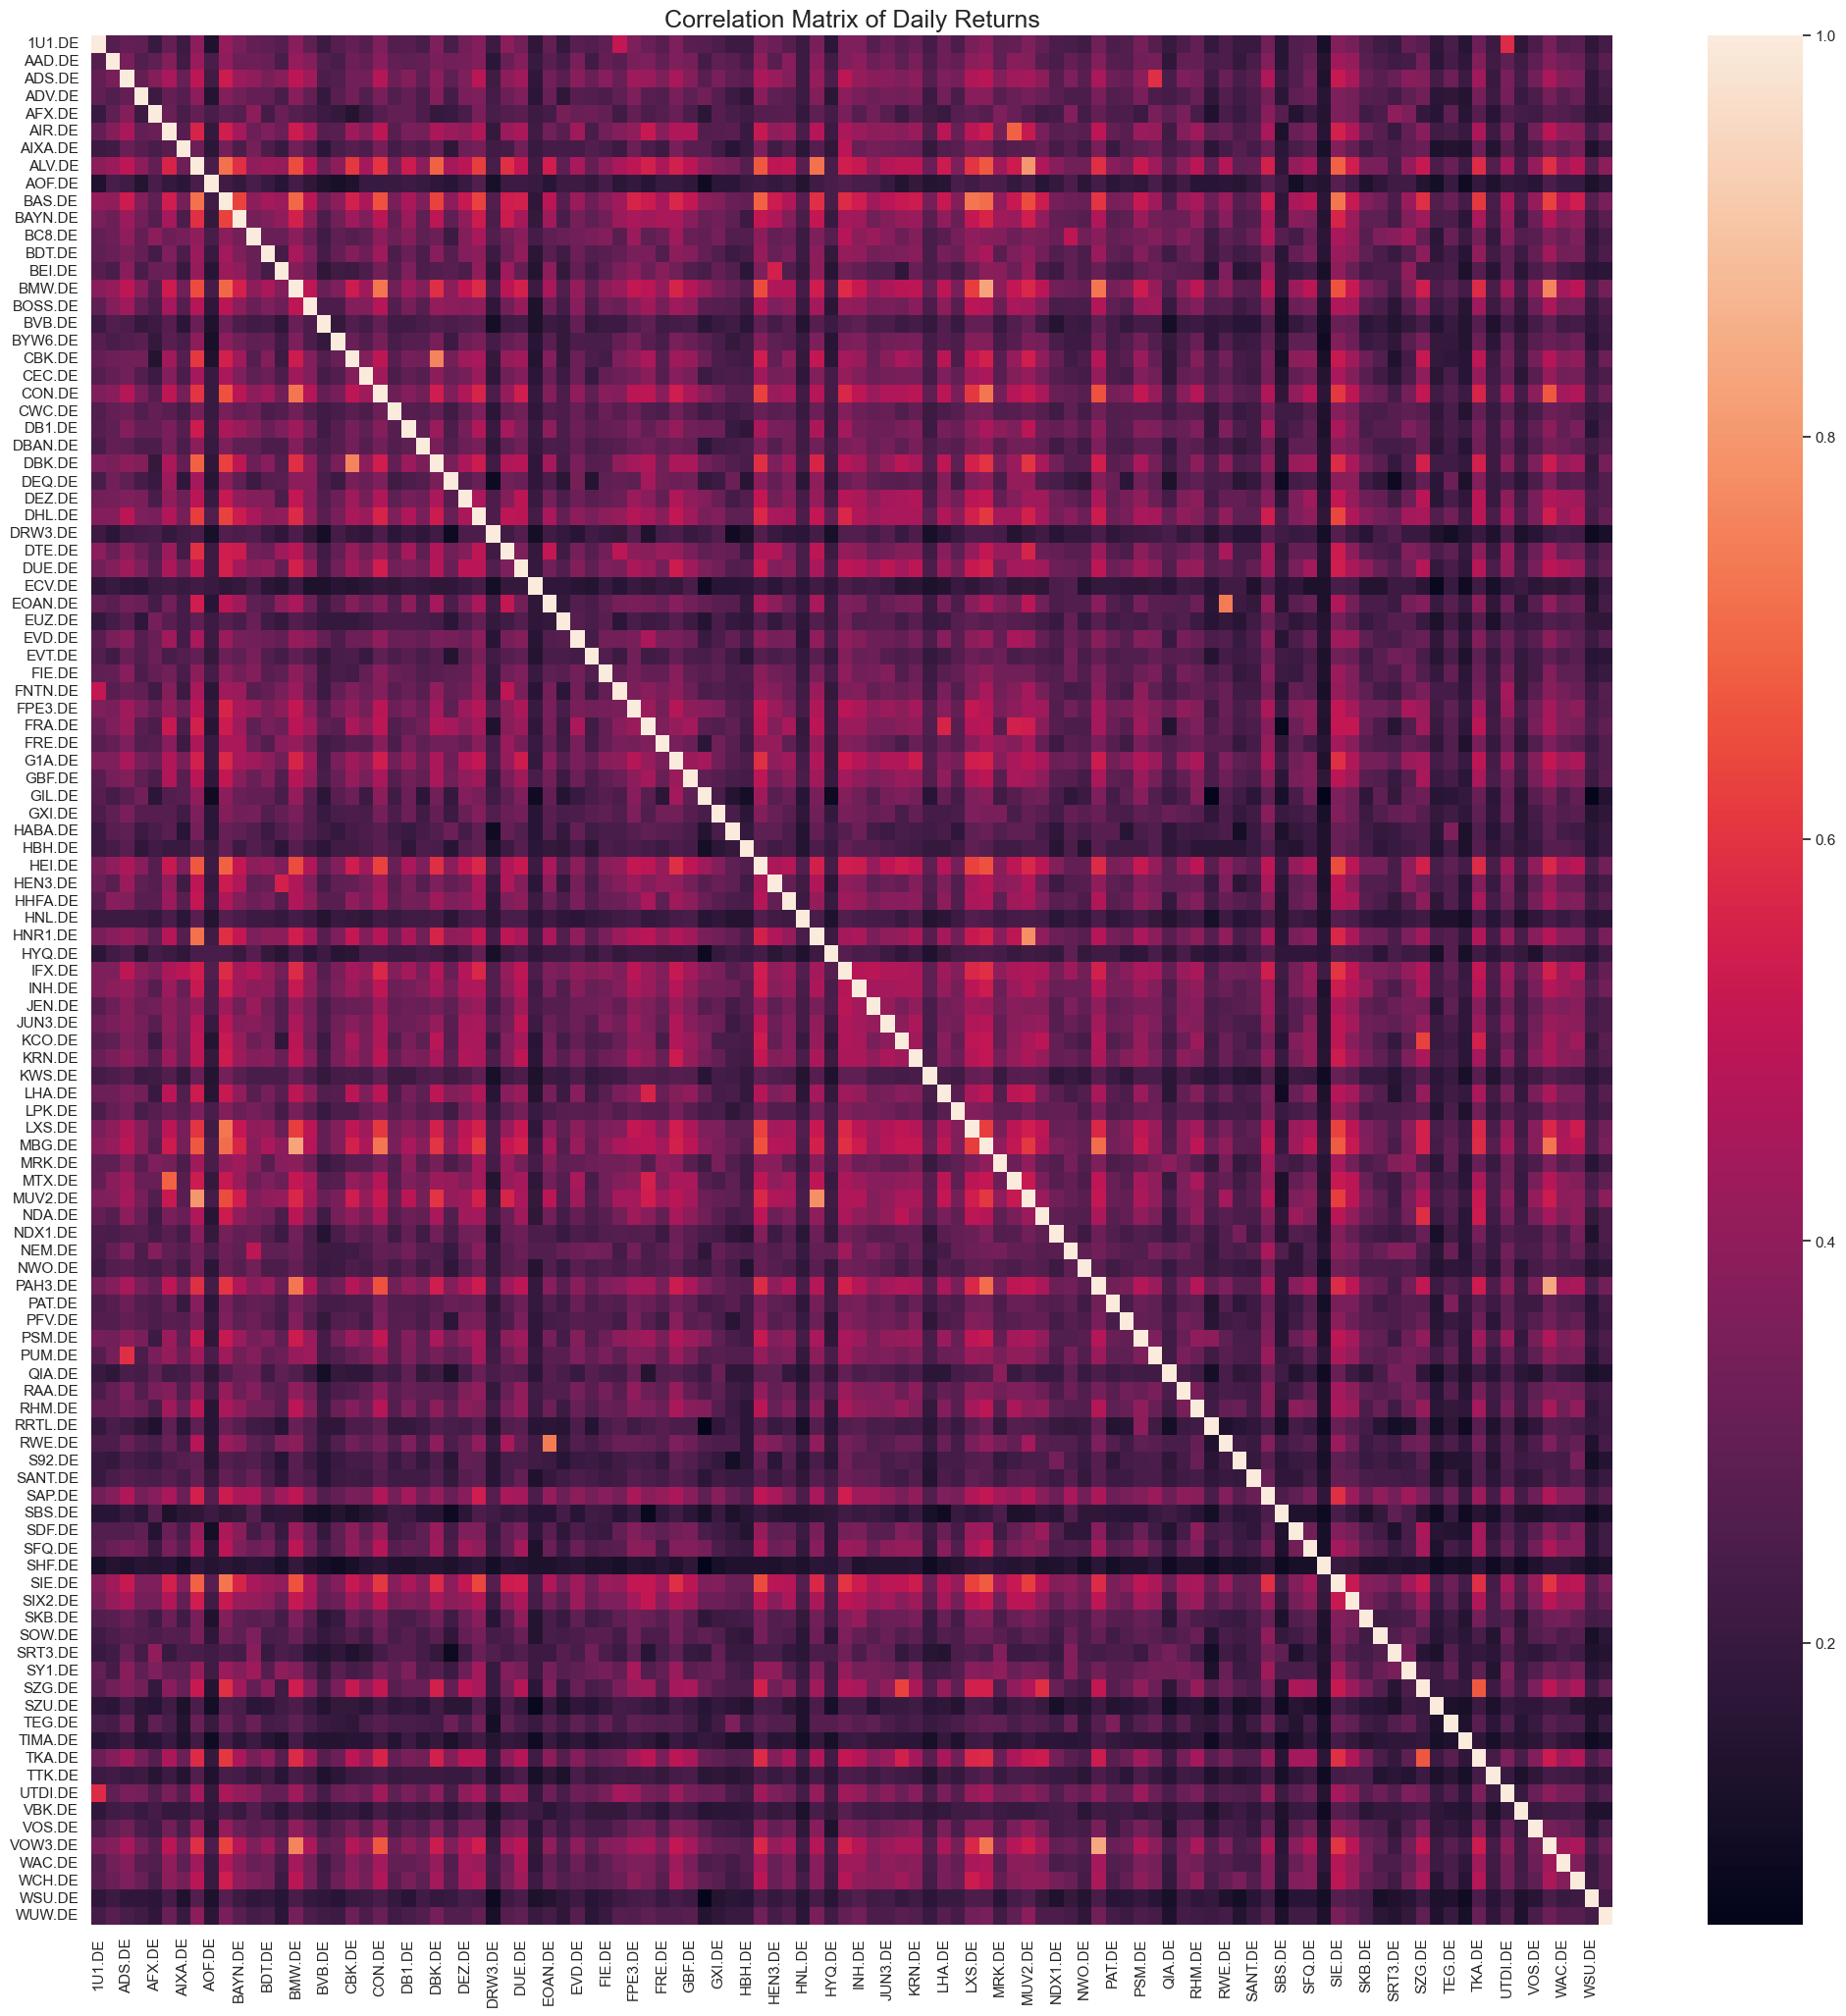

In [28]:
corr_matrix = rts.corr().round(decimals=2)

sns.set(rc={'figure.figsize':(25, 25)})
sns.heatmap(corr_matrix, annot=False)
plt.title(
    'Correlation Matrix of Daily Returns'
    , fontsize=18
)

plt.show();

In [127]:
print(np.mean(np.mean(corr_matrix[corr_matrix != 1], axis=1)))

0.3020387677397024


In [131]:
print(np.mean(corr_matrix[corr_matrix != 1], axis=1).sort_values(ascending=False))

BAS.DE     0.437570
SIE.DE     0.436355
ALV.DE     0.436262
MBG.DE     0.428598
BMW.DE     0.423084
             ...   
ECV.DE     0.184206
SZU.DE     0.181589
SBS.DE     0.174393
TIMA.DE    0.168879
SHF.DE     0.142897
Length: 108, dtype: float64


In [124]:
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

corr_pairs[corr_pairs != 1]

VOW3.DE  PAH3.DE    0.84
PAH3.DE  VOW3.DE    0.84
MBG.DE   BMW.DE     0.83
BMW.DE   MBG.DE     0.83
ALV.DE   MUV2.DE    0.80
                    ... 
RRTL.DE  GIL.DE     0.07
GIL.DE   RRTL.DE    0.07
WSU.DE   GIL.DE     0.07
GIL.DE   SHF.DE     0.06
SHF.DE   GIL.DE     0.06
Length: 11556, dtype: float64

## Correlation by industry

In [171]:
for industry in sectors_df.industry.unique().tolist():
    df = rts[(rts # The returns
                 .columns 
                 .intersection( # where the stocks come from a particular industry
                    sectors_df.symbol[sectors_df.industry == industry].tolist()
                )
            )]

    if df.shape[1] > 1: # Only if the dataset contains more than 1 stock
        avg = np.mean( # Calculate the average
            np.mean( # of averages
                df.corr()
                , axis=1
            )
        ).round(3)
    
        print(f'Average correlation in {industry}: {avg}')


Average correlation in Specialty Chemicals: 0.479
Average correlation in Telecom Services: 0.604
Average correlation in Real Estate Services: 0.553
Average correlation in Footwear & Accessories: 0.797
Average correlation in Medical Instruments & Supplies: 0.475
Average correlation in Aerospace & Defense: 0.685
Average correlation in Software - Application: 0.551
Average correlation in Information Technology Services: 0.587
Average correlation in Auto Parts: 0.614
Average correlation in Household & Personal Products: 0.773
Average correlation in Auto Manufacturers: 0.823
Average correlation in Entertainment: 0.649
Average correlation in Conglomerates: 0.68
Average correlation in Banks - Regional: 0.878
Average correlation in Specialty Industrial Machinery: 0.405
Average correlation in Drug Manufacturers - Specialty & Generic: 0.658
Average correlation in Medical Devices: 0.476
Average correlation in Utilities - Diversified: 0.868
Average correlation in Insurance - Reinsurance: 0.891
Ave

In [167]:
rts[rts.columns.intersection(sectors_df.symbol[sectors_df.industry == 'Farm & Heavy Construction Machinery'].tolist())].shape

(3450, 1)